In [53]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization
#from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
train_path = 'keras_cnn_cat_vs_dog/train'
valid_path = 'keras_cnn_cat_vs_dog/validation'
test_path = 'keras_cnn_cat_vs_dog/test'

### Count Image Files in Folders

In [55]:
import os

image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

def count_images(path):
    count = 0
    for root, dirs, files in os.walk(path):
        for file in files:
            if any(file.endswith(extension) for extension in image_extensions):
                count += 1
    return count

#path = os.getcwd()
path = valid_path
image_count = count_images(path)
print("Number of image files:", image_count)

Number of image files: 60


In [71]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dogs', 'cats'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['dogs', 'cats'], batch_size=6)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['dogs', 'cats'], batch_size=10)

Found 200 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [72]:
# plot function, used to plot images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims= np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [73]:
imgs, labels = next(train_batches)

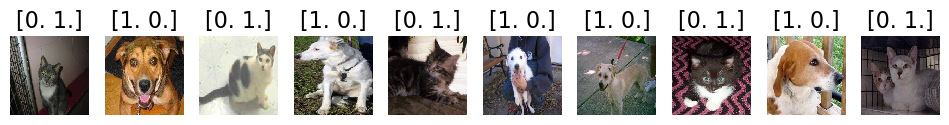

In [74]:
plots(imgs, titles=labels)

### Build and train CNN

In [75]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)), 
    Flatten(),
    Dense(2, activation='softmax')
])

In [76]:
model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
model.fit(train_batches, steps_per_epoch=20, validation_data=valid_batches, validation_steps=10, epochs=5, verbose=2)

Epoch 1/5
20/20 - 4s - loss: 586.4881 - accuracy: 0.5350 - val_loss: 267.0406 - val_accuracy: 0.4833 - 4s/epoch - 199ms/step
Epoch 2/5
20/20 - 3s - loss: 125.6289 - accuracy: 0.6550 - val_loss: 112.5755 - val_accuracy: 0.5833 - 3s/epoch - 150ms/step
Epoch 3/5
20/20 - 3s - loss: 51.9994 - accuracy: 0.7500 - val_loss: 177.2567 - val_accuracy: 0.5000 - 3s/epoch - 142ms/step
Epoch 4/5
20/20 - 3s - loss: 37.3053 - accuracy: 0.8250 - val_loss: 111.4384 - val_accuracy: 0.5000 - 3s/epoch - 144ms/step
Epoch 5/5
20/20 - 3s - loss: 43.9595 - accuracy: 0.7950 - val_loss: 241.3237 - val_accuracy: 0.4667 - 3s/epoch - 150ms/step


#### Predict

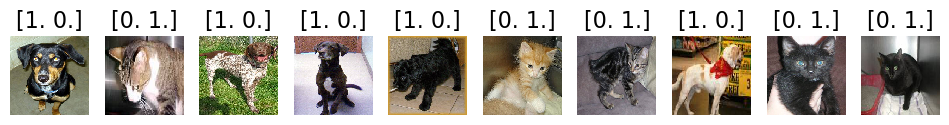

In [78]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [79]:
test_labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [80]:
test_labels = test_labels[:, 0]

In [81]:
test_labels

array([1., 0., 1., 1., 1., 0., 0., 1., 0., 0.], dtype=float32)

In [82]:
test_labels.shape

(10,)

In [83]:
predictions = model.predict(test_batches, steps=1, verbose=0)
predictions.shape

(10, 2)

In [84]:
np.set_printoptions(suppress=True)
predictions

array([[0.99999994, 0.        ],
       [0.99999994, 0.        ],
       [0.99999994, 0.        ],
       [0.99999994, 0.        ],
       [0.        , 0.99999994],
       [0.99999994, 0.        ],
       [0.99999994, 0.        ],
       [0.99999994, 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]], dtype=float32)

In [85]:
predictions = predictions[:, 0]

In [86]:
predictions = np.where(predictions > 0.5, 1, 0)
predictions

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [87]:
cm = confusion_matrix(test_labels, predictions)

In [88]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[0 5]
 [1 4]]


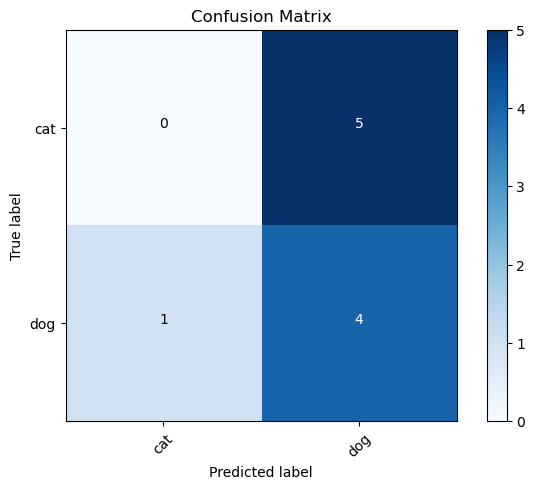

In [89]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title="Confusion Matrix")

In [90]:
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = precision_score(test_labels, predictions)
f1score = f1_score(test_labels, predictions)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1score)

Accuracy:  0.4
Precision:  0.4444444444444444
Recall:  0.4444444444444444
F1-Score:  0.5714285714285714


#### Build Fine-tuned VGG16 Model

In [91]:
from keras.applications.vgg16 import VGG16
vgg16_model = VGG16()

In [92]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [93]:
type(vgg16_model)

keras.engine.functional.Functional

In [94]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [95]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [96]:
model.layers.pop()

In [97]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [98]:
for layer in model.layers:
    layer.trainable = False

In [99]:
model.add(Dense(2, activation='softmax'))

In [100]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

#### Train the fine-tuned VGG16 model

In [101]:
model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [102]:
model.fit(train_batches, steps_per_epoch=20, validation_data=valid_batches, validation_steps=10, epochs=10, verbose=2)

Epoch 1/10
20/20 - 73s - loss: 0.6960 - accuracy: 0.4150 - val_loss: 0.6973 - val_accuracy: 0.3167 - 73s/epoch - 4s/step
Epoch 2/10
20/20 - 79s - loss: 0.6950 - accuracy: 0.4300 - val_loss: 0.6965 - val_accuracy: 0.4000 - 79s/epoch - 4s/step
Epoch 3/10
20/20 - 74s - loss: 0.6941 - accuracy: 0.4650 - val_loss: 0.6956 - val_accuracy: 0.4667 - 74s/epoch - 4s/step
Epoch 4/10
20/20 - 74s - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6947 - val_accuracy: 0.5167 - 74s/epoch - 4s/step
Epoch 5/10
20/20 - 74s - loss: 0.6923 - accuracy: 0.5250 - val_loss: 0.6938 - val_accuracy: 0.5667 - 74s/epoch - 4s/step
Epoch 6/10
20/20 - 74s - loss: 0.6914 - accuracy: 0.5450 - val_loss: 0.6929 - val_accuracy: 0.6000 - 74s/epoch - 4s/step
Epoch 7/10
20/20 - 74s - loss: 0.6905 - accuracy: 0.5900 - val_loss: 0.6920 - val_accuracy: 0.6333 - 74s/epoch - 4s/step
Epoch 8/10
20/20 - 74s - loss: 0.6895 - accuracy: 0.5950 - val_loss: 0.6911 - val_accuracy: 0.6500 - 74s/epoch - 4s/step
Epoch 9/10
20/20 - 73s - loss: 0

In [103]:
predictions = model.predict(test_batches, steps=1, verbose=0)
predictions.shape

(10, 2)

In [104]:
np.set_printoptions(suppress=True)
predictions

array([[0.5134397 , 0.48656029],
       [0.49842018, 0.5015798 ],
       [0.4971371 , 0.5028628 ],
       [0.50037855, 0.49962133],
       [0.49055892, 0.5094411 ],
       [0.49752685, 0.50247306],
       [0.5051397 , 0.49486023],
       [0.49007085, 0.50992906],
       [0.49249974, 0.5075003 ],
       [0.49464077, 0.5053592 ]], dtype=float32)

In [105]:
predictions = predictions[:, 0]

In [106]:
predictions = np.where(predictions > 0.5, 1, 0)
predictions

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [107]:
cm = confusion_matrix(test_labels, predictions)

In [108]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4 1]
 [3 2]]


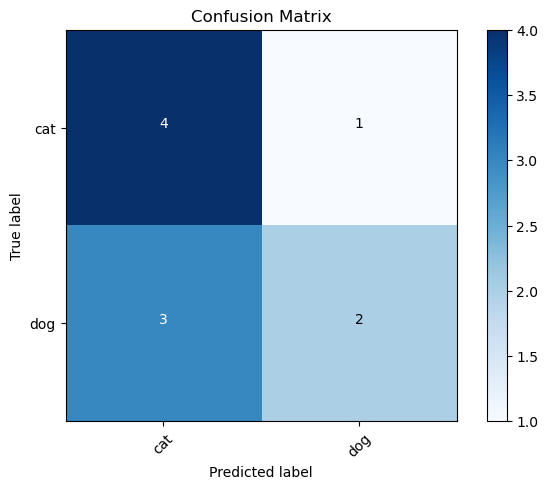

In [109]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title="Confusion Matrix")

In [110]:
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = precision_score(test_labels, predictions)
f1score = f1_score(test_labels, predictions)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1score)

Accuracy:  0.6
Precision:  0.6666666666666666
Recall:  0.6666666666666666
F1-Score:  0.5
